# AnoGAN
GANの以上検出モデルの論文をまとめたスライド  
https://www.slideshare.net/Koichirotamura2/gan-anogan?ref=https://note.com/koichirot11/n/n24151f3c7af8  
AnoGANの解説と実装  
https://qiita.com/NakaokaRei/items/231ec4efe42dfe79d1ff  
GANによる異常検出の有名どころをまとめた記事  
https://note.com/koichirot11/n/n24151f3c7af8

In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


# Generatorの実装

In [16]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


# Discriminatorの実装

In [17]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        feature = out  # 最後にチャネルを1つに集約する手前の情報 torch.Size([1, 512, 4, 4])
        feature = feature.view(feature.size()[0], -1)  # 2次元に変換

        out = self.last(out)

        return out, feature

In [18]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)
G = Generator(z_dim=20, image_size=64)

# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 偽画像をDに入力
d_out = D(fake_images)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out[0]))

# feature
print(d_out[1].shape)

tensor([[[[0.5016]]]], grad_fn=<SigmoidBackward>)
torch.Size([1, 8192])


# DataLoaderの作成

In [19]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)
    
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform, return_label=True):
        self.file_list = file_list
        self.transform = transform
        self.return_label = return_label
        
    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img_labels = img_path.split('/')[-1][4]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        if self.return_label:
            return img_transformed, img_labels
        else:
            return img_transformed

In [20]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std), return_label=False)

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges= next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 64, 64])


# GANを学習させる

In [28]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [29]:
# モデルを学習させる関数を作成


def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real, _ = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        
        log_epoch = {'epoch' : epoch+1,
                     'g_loss' : epoch_g_loss/batch_size,
                     'd_loss' : epoch_d_loss/batch_size}
        logs.append(log_epoch)
        df = pd.DataFrame(logs) 
        df.to_csv('mnist_log_output.csv')  

    
    print("総イテレーション回数:", iteration)

    return G, D


In [30]:
# 学習・検証を実行する
# 8分ほどかかる
num_epochs = 50
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


使用デバイス： cuda:0
-------------
Epoch 0/50
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.0737 ||Epoch_G_Loss:0.2199
timer:  0.8568 sec.
-------------
Epoch 1/50
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0333 ||Epoch_G_Loss:0.3459
timer:  0.3695 sec.
-------------
Epoch 2/50
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.2437 ||Epoch_G_Loss:0.4830
timer:  0.3595 sec.
-------------
Epoch 3/50
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.0593 ||Epoch_G_Loss:0.1375
timer:  0.3581 sec.
-------------
Epoch 4/50
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0356 ||Epoch_G_Loss:0.3006
timer:  0.3604 sec.
-------------
Epoch 5/50
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0039 ||Epoch_G_Loss:0.4330
timer:  0.3595 sec.
-------------
Epoch 6/50
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.2285 ||Epoch_G_Loss:0.2044
timer:  0.3596 sec.
-------------
Epoch 7/50
-------------
（train）


# AnoGANの本体

In [32]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):
    
    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x - fake_img) # (batch_size, channel, height, width)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1) # (batch_size, channel*height*width)
    residual_loss = torch.sum(residual_loss, dim=1) # (batch, sum)
    
    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量を取り出す
    _, x_feature = D(x)
    _, G_feature = D(fake_img)
    
    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature - G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
    # ミニバッチごとに2種類の損失を足し算する
    loss_epoch = (1 - Lambda) * residual_loss + Lambda * discrimination_loss
    
    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_epoch)
    
    return total_loss, loss_epoch, residual_loss

# テスト用Dataloader 

In [23]:
def make_test_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(5):
        img_path = "./data/test/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


# ファイルリストを作成
test_img_list = make_test_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std), return_label=False)

# DataLoaderを作成
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


In [24]:
for i, (images, labels) in enumerate(test_dataloader):
    print(labels)
    index = [i for i, x in enumerate(labels) if x == '8']

ValueError: too many values to unpack (expected 2)

In [25]:
loss_epoch[index]

NameError: name 'loss_epoch' is not defined

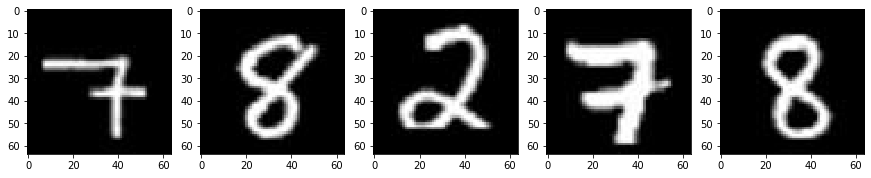

In [26]:
# テストデータの確認
batch_iterator = iter(test_dataloader)  # イテレータに変換
images = next(batch_iterator)  

# 1番目のミニバッチを取り出す

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')

# 学習検証

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 異常検知したい画像
x = images[0:5] # (batch_size=5, channel=1, 64, 64)
x = x.to(device)

# 異常検知したい画像を生成するための、初期乱数
z = torch.randn(5, 20).to(device) # batch_size=5, z_dim=20
z = z.view(z.size(0), z.size(1), 1, 1)

# 変数zを微分を求めることが可能なように、requires_gradをTrueに設定
z.requires_grad = True

# 変数zを更新できるように、zの最適化関数を求める
z_optimizer = torch.optim.Adam([z], lr=1e-3)

logs = []
# zを求める
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, loss_epoch, _ = Anomaly_score(x, fake_img, D, Lambda=0.1)
    
    z_optimizer.zero_grad() # 勾配の初期化
    loss.backward() # バックプロパゲーション
    z_optimizer.step() # 重みの更新

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))
        
    if epoch % 100 == 0:
        log_epoch = {'epoch' : epoch+1,
                                 'total_loss' : loss.item(),
                                 '1' : loss_epoch[0].item(),
                                 '2' : loss_epoch[1].item(),
                                 '3' : loss_epoch[2].item(),
                                 '4' : loss_epoch[3].item(),
                                 '5' : loss_epoch[4].item()}
        logs.append(log_epoch)
df = pd.DataFrame(logs) 

epoch 0 || loss_total:6849 
epoch 1000 || loss_total:4811 
epoch 2000 || loss_total:4276 
epoch 3000 || loss_total:4174 
epoch 4000 || loss_total:4102 
epoch 5000 || loss_total:4029 


In [37]:
fake_img[0]

torch.Size([1, 64, 64])

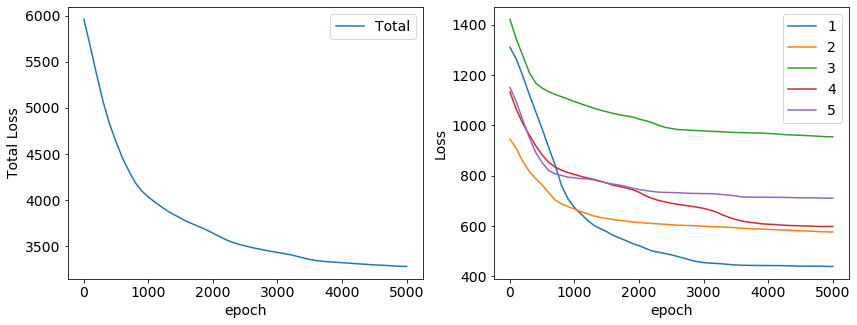

In [45]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(df['epoch'], df['total_loss'], '-', label='Total')
plt.xlabel('epoch')
plt.ylabel('Total Loss')
plt.legend()

plt.subplot(1,2,2)
for i in range(5):
    plt.plot(df['epoch'], df.iloc[:,i+2], label=str(i+1))

plt.xlabel('epoch')
plt.ylabel('Loss')
    
plt.legend()
plt.show()

total loss: [682. 843. 946. 720. 838.]


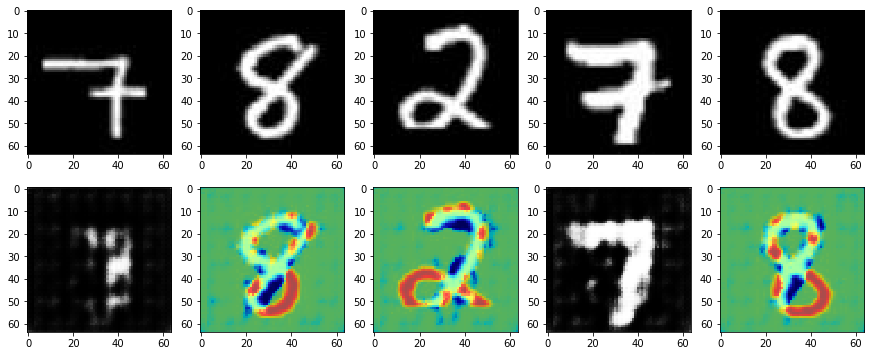

In [38]:
# 画像を生成
fake_img = G_update(z)

# 損失を求める
loss, loss_epoch, residual_loss_epoch = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

loss_epoch = loss_epoch.cpu().detach().numpy()
print('total loss:', np.round(loss_epoch, 0))

def show_anomaly_image(original_img, generated_img):

    residual_img = original_img - generated_img
    residual_img = (residual_img + 2) / 4
    residual_img = (255 * residual_img).astype(np.uint8)

    original_img = (original_img*127.5+127.5).astype(np.uint8)

    original_x_color = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(residual_img, cv2.COLORMAP_JET)

    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)
    plt.imshow(cv2.cvtColor(show,cv2.COLOR_BGR2RGB))


fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段にテストデータを
    plt.subplot(2, 5, i+1)
    original_img = images[i][0].cpu().detach().numpy()
    plt.imshow(original_img, 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    generated_img = fake_img[i][0].cpu().detach().numpy()
    
    if loss_epoch[i] > 800:
        show_anomaly_image(original_img, generated_img)
    else:
        plt.imshow(generated_img, 'gray')

In [11]:
G = Generator(z_dim=20)
G.load_state_dict(torch.load('AnoGAN_result/generator'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G.to(device)

Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(20, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (last): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride

# Efficient GANの作成
論文  
https://arxiv.org/pdf/1802.06222v2.pdf  
論文解説スライド  
https://www.slideshare.net/Koichirotamura2/ss-131148940?next_slideshow=1  
モデルの元となったBiGAN  
https://arxiv.org/pdf/1605.09782.pdf  


In [14]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data  as data 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

# Setup seeds
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim=20):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                                  kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1,
                                              kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        
        # 転置畳み込み層に入れるためにテンソルの形を整形
        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)
        
        return out

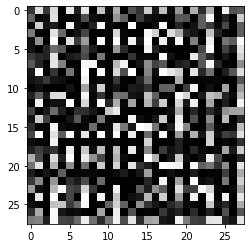

In [13]:
G = Generator(z_dim=20)
G.train()

# 入力する乱数
# バッチノーマライゼーションがあるのでミニバッチ数は2以上
input_z = torch.randn(2, 20)

# 偽画像を出力
fake_images = G(input_z)  # torch.Size([2, 1, 28, 28])
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

# Discriminatorの実装

In [25]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()
        
        # 画像側の入力処理。 生成画像G(z)の処理
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64,
                                 kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.x_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, 
                                 kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))
        
        # 乱数側の入力処理。　生成乱数E(x)の処理
        self.z_layer1 = nn.Linear(z_dim, 512)
        
        # 最後の判定 3648 = 64*7*7 + 512
        # x_outとz_outを結合し、全結合層で判定
        self.last1= nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last2 = nn.Linear(1024, 1)
        
    def forward(self, x ,z):
        '''
        x : 生成画像G(z)
        z : 生成乱数E(x)
        '''
        # 画像側の入力処理
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)
        
        # 乱数側の入力処理
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)
        
        # x_outとz_outを結合し、全結合層で判定
        x_out = x_out.view(-1, 64*7*7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)
        
        feature = out # 最後にチャネルを1つに集約する手前の情報
        feature = feature.view(feature.size()[0], -1)
        
        out = self.last2(feature)
        
        return out, feature

In [26]:
# 動作確認
D = Discriminator(z_dim=20)

# 偽画像を生成
input_z = torch.randn(2, 20)
fake_images = G(input_z)

# 偽画像をDに入力
d_out, _ = D(fake_images, input_z)

# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))

tensor([[0.4657],
        [0.4620]], grad_fn=<SigmoidBackward>)


In [27]:
class Encoder(nn.Module):
    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()
        
        # 注意：白黒画像なので入力チャネルは1つだけ
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2= nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.last = nn.Linear(128*7*7, z_dim)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.view(-1, 128*7*7)
        out = self.last(out)
        
        return out

In [31]:
E = Encoder(z_dim=20)
# 入力する画像データ
x = fake_images
# 画像からzをEncode
z =E(x)

print(z.shape)
print(z)

torch.Size([2, 20])
tensor([[-0.0669, -0.0757,  0.1279,  0.1145, -0.0825, -0.0918,  0.3252, -0.0430,
         -0.0954, -0.0985, -0.0140, -0.2145, -0.3624, -0.1153, -0.2615,  0.2413,
          0.0056, -0.2329,  0.2985, -0.0640],
        [ 0.0390, -0.2289,  0.1372,  0.0361, -0.0115,  0.1961,  0.3533, -0.0501,
         -0.0699, -0.1244, -0.4614, -0.1281, -0.0493, -0.0655, -0.3409, -0.0612,
         -0.1020, -0.0588,  0.2883, -0.2062]], grad_fn=<AddmmBackward>)


# DataLoaderの作成

In [32]:
def make_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed


In [33]:
# DataLoaderの作成と動作確認

# ファイルリストを作成
train_img_list=make_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 28, 28])


In [45]:
def train_model(G, D, E, dataloader, num_epochs):
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    
    # 最適化手法の設定
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 誤差関数を定義
    # BCEWithLogitsLossは入力にシグモイド（logit）をかけてから、
    # バイナリークロスエントロピーを計算
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64
    
    # ネットワークをGPUへ
    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    E.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_e_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')
        
        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue
                
            # ミニバッチサイズの1もしくは0のラベル役のテンソルを作成
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)
            
            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            
            # 真の画像を判定　
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)
            
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)
            
            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake
            
            # バックプロパゲーション
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)
            
            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            # バックプロパゲーション
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            # --------------------
            # 3. Encoderの学習
            # --------------------
            
            # 真の画像のzを推定
            z_out_real = E(imges)
            d_out_real, _ =D(imges, z_out_real)
            
            # 誤差を計算
            e_loss = criterion(d_out_real.view(-1), label_fake)
            
            # バックプロパゲーション
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()
            
            # --------------------
            # 4. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1
            
        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()
        
        if epoch % 100 == 0:
            log_epoch = {'epoch' : epoch+1,
                                 'd_loss' : epoch_d_loss/batch_size,
                                 'g_loss' : epoch_g_loss/batch_size,
                                 'e_loss' : epoch_e_loss/batch_size}

            logs.append(log_epoch)
            
    print("総イテレーション回数:", iteration)
    df = pd.DataFrame(logs)
    df.to_csv('efficientGAN_loss.csv')
    return G, D, E

In [35]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # 全結合層Linearの初期化
        m.bias.data.fill_(0)
        
# 初期化の実施
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")


ネットワークの初期化完了


In [47]:
# 学習・検証を実行する
# 15分ほどかかる
num_epochs = 2000
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 0/2000
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.0919 ||Epoch_G_Loss:0.1471 ||Epoch_E_Loss:0.1539
timer:  0.2065 sec.
-------------
Epoch 1/2000
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0921 ||Epoch_G_Loss:0.1485 ||Epoch_E_Loss:0.1517
timer:  0.1773 sec.
-------------
Epoch 2/2000
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.0940 ||Epoch_G_Loss:0.1527 ||Epoch_E_Loss:0.1554
timer:  0.1726 sec.
-------------
Epoch 3/2000
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.0876 ||Epoch_G_Loss:0.1412 ||Epoch_E_Loss:0.1647
timer:  0.1700 sec.
-------------
Epoch 4/2000
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0735 ||Epoch_G_Loss:0.1683 ||Epoch_E_Loss:0.1767
timer:  0.1707 sec.
-------------
Epoch 5/2000
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0696 ||Epoch_G_Loss:0.1679 ||Epoch_E_Loss:0.1858
timer:  0.1705 sec.
-------------
Epoch 6/2000
----------

-------------
epoch 52 || Epoch_D_Loss:0.1719 ||Epoch_G_Loss:0.1029 ||Epoch_E_Loss:0.1064
timer:  0.1716 sec.
-------------
Epoch 53/2000
-------------
（train）
-------------
epoch 53 || Epoch_D_Loss:0.1618 ||Epoch_G_Loss:0.1096 ||Epoch_E_Loss:0.1097
timer:  0.1710 sec.
-------------
Epoch 54/2000
-------------
（train）
-------------
epoch 54 || Epoch_D_Loss:0.1470 ||Epoch_G_Loss:0.1156 ||Epoch_E_Loss:0.1185
timer:  0.1716 sec.
-------------
Epoch 55/2000
-------------
（train）
-------------
epoch 55 || Epoch_D_Loss:0.1242 ||Epoch_G_Loss:0.1280 ||Epoch_E_Loss:0.1337
timer:  0.1713 sec.
-------------
Epoch 56/2000
-------------
（train）
-------------
epoch 56 || Epoch_D_Loss:0.1120 ||Epoch_G_Loss:0.1325 ||Epoch_E_Loss:0.1419
timer:  0.1720 sec.
-------------
Epoch 57/2000
-------------
（train）
-------------
epoch 57 || Epoch_D_Loss:0.1008 ||Epoch_G_Loss:0.1535 ||Epoch_E_Loss:0.1497
timer:  0.1708 sec.
-------------
Epoch 58/2000
-------------
（train）
-------------
epoch 58 || Epoch_D_Loss:0

-------------
epoch 104 || Epoch_D_Loss:0.1408 ||Epoch_G_Loss:0.0979 ||Epoch_E_Loss:0.1157
timer:  0.1722 sec.
-------------
Epoch 105/2000
-------------
（train）
-------------
epoch 105 || Epoch_D_Loss:0.1424 ||Epoch_G_Loss:0.1208 ||Epoch_E_Loss:0.1131
timer:  0.1710 sec.
-------------
Epoch 106/2000
-------------
（train）
-------------
epoch 106 || Epoch_D_Loss:0.1389 ||Epoch_G_Loss:0.1011 ||Epoch_E_Loss:0.1178
timer:  0.1716 sec.
-------------
Epoch 107/2000
-------------
（train）
-------------
epoch 107 || Epoch_D_Loss:0.1470 ||Epoch_G_Loss:0.1040 ||Epoch_E_Loss:0.1100
timer:  0.1716 sec.
-------------
Epoch 108/2000
-------------
（train）
-------------
epoch 108 || Epoch_D_Loss:0.1488 ||Epoch_G_Loss:0.0960 ||Epoch_E_Loss:0.1069
timer:  0.1720 sec.
-------------
Epoch 109/2000
-------------
（train）
-------------
epoch 109 || Epoch_D_Loss:0.1340 ||Epoch_G_Loss:0.1221 ||Epoch_E_Loss:0.1148
timer:  0.1716 sec.
-------------
Epoch 110/2000
-------------
（train）
-------------
epoch 110 || E

-------------
epoch 156 || Epoch_D_Loss:0.1115 ||Epoch_G_Loss:0.1150 ||Epoch_E_Loss:0.1180
timer:  0.1737 sec.
-------------
Epoch 157/2000
-------------
（train）
-------------
epoch 157 || Epoch_D_Loss:0.1118 ||Epoch_G_Loss:0.1138 ||Epoch_E_Loss:0.1151
timer:  0.1725 sec.
-------------
Epoch 158/2000
-------------
（train）
-------------
epoch 158 || Epoch_D_Loss:0.1114 ||Epoch_G_Loss:0.1160 ||Epoch_E_Loss:0.1160
timer:  0.1730 sec.
-------------
Epoch 159/2000
-------------
（train）
-------------
epoch 159 || Epoch_D_Loss:0.1140 ||Epoch_G_Loss:0.1204 ||Epoch_E_Loss:0.1144
timer:  0.1762 sec.
-------------
Epoch 160/2000
-------------
（train）
-------------
epoch 160 || Epoch_D_Loss:0.1155 ||Epoch_G_Loss:0.1225 ||Epoch_E_Loss:0.1143
timer:  0.1753 sec.
-------------
Epoch 161/2000
-------------
（train）
-------------
epoch 161 || Epoch_D_Loss:0.1131 ||Epoch_G_Loss:0.1190 ||Epoch_E_Loss:0.1155
timer:  0.1839 sec.
-------------
Epoch 162/2000
-------------
（train）
-------------
epoch 162 || E

-------------
epoch 208 || Epoch_D_Loss:0.1365 ||Epoch_G_Loss:0.1307 ||Epoch_E_Loss:0.1377
timer:  0.1733 sec.
-------------
Epoch 209/2000
-------------
（train）
-------------
epoch 209 || Epoch_D_Loss:0.1528 ||Epoch_G_Loss:0.1081 ||Epoch_E_Loss:0.1243
timer:  0.1721 sec.
-------------
Epoch 210/2000
-------------
（train）
-------------
epoch 210 || Epoch_D_Loss:0.1562 ||Epoch_G_Loss:0.1152 ||Epoch_E_Loss:0.1278
timer:  0.1736 sec.
-------------
Epoch 211/2000
-------------
（train）
-------------
epoch 211 || Epoch_D_Loss:0.1528 ||Epoch_G_Loss:0.1119 ||Epoch_E_Loss:0.1236
timer:  0.1718 sec.
-------------
Epoch 212/2000
-------------
（train）
-------------
epoch 212 || Epoch_D_Loss:0.1497 ||Epoch_G_Loss:0.1090 ||Epoch_E_Loss:0.1287
timer:  0.1731 sec.
-------------
Epoch 213/2000
-------------
（train）
-------------
epoch 213 || Epoch_D_Loss:0.1537 ||Epoch_G_Loss:0.1053 ||Epoch_E_Loss:0.1267
timer:  0.1717 sec.
-------------
Epoch 214/2000
-------------
（train）
-------------
epoch 214 || E

-------------
epoch 260 || Epoch_D_Loss:0.1290 ||Epoch_G_Loss:0.1207 ||Epoch_E_Loss:0.1218
timer:  0.1736 sec.
-------------
Epoch 261/2000
-------------
（train）
-------------
epoch 261 || Epoch_D_Loss:0.1362 ||Epoch_G_Loss:0.1173 ||Epoch_E_Loss:0.1193
timer:  0.1723 sec.
-------------
Epoch 262/2000
-------------
（train）
-------------
epoch 262 || Epoch_D_Loss:0.1508 ||Epoch_G_Loss:0.1049 ||Epoch_E_Loss:0.1114
timer:  0.1735 sec.
-------------
Epoch 263/2000
-------------
（train）
-------------
epoch 263 || Epoch_D_Loss:0.1699 ||Epoch_G_Loss:0.0892 ||Epoch_E_Loss:0.0999
timer:  0.1745 sec.
-------------
Epoch 264/2000
-------------
（train）
-------------
epoch 264 || Epoch_D_Loss:0.1743 ||Epoch_G_Loss:0.0852 ||Epoch_E_Loss:0.0957
timer:  0.1755 sec.
-------------
Epoch 265/2000
-------------
（train）
-------------
epoch 265 || Epoch_D_Loss:0.1688 ||Epoch_G_Loss:0.1027 ||Epoch_E_Loss:0.0962
timer:  0.1717 sec.
-------------
Epoch 266/2000
-------------
（train）
-------------
epoch 266 || E

-------------
epoch 312 || Epoch_D_Loss:0.1362 ||Epoch_G_Loss:0.1035 ||Epoch_E_Loss:0.0987
timer:  0.1732 sec.
-------------
Epoch 313/2000
-------------
（train）
-------------
epoch 313 || Epoch_D_Loss:0.1328 ||Epoch_G_Loss:0.1021 ||Epoch_E_Loss:0.1016
timer:  0.1729 sec.
-------------
Epoch 314/2000
-------------
（train）
-------------
epoch 314 || Epoch_D_Loss:0.1351 ||Epoch_G_Loss:0.1013 ||Epoch_E_Loss:0.0978
timer:  0.1743 sec.
-------------
Epoch 315/2000
-------------
（train）
-------------
epoch 315 || Epoch_D_Loss:0.1351 ||Epoch_G_Loss:0.1031 ||Epoch_E_Loss:0.0972
timer:  0.1732 sec.
-------------
Epoch 316/2000
-------------
（train）
-------------
epoch 316 || Epoch_D_Loss:0.1329 ||Epoch_G_Loss:0.0960 ||Epoch_E_Loss:0.0994
timer:  0.1742 sec.
-------------
Epoch 317/2000
-------------
（train）
-------------
epoch 317 || Epoch_D_Loss:0.1305 ||Epoch_G_Loss:0.1046 ||Epoch_E_Loss:0.1030
timer:  0.1730 sec.
-------------
Epoch 318/2000
-------------
（train）
-------------
epoch 318 || E

-------------
epoch 364 || Epoch_D_Loss:0.1532 ||Epoch_G_Loss:0.1042 ||Epoch_E_Loss:0.1037
timer:  0.1729 sec.
-------------
Epoch 365/2000
-------------
（train）
-------------
epoch 365 || Epoch_D_Loss:0.1441 ||Epoch_G_Loss:0.0951 ||Epoch_E_Loss:0.1090
timer:  0.1716 sec.
-------------
Epoch 366/2000
-------------
（train）
-------------
epoch 366 || Epoch_D_Loss:0.1477 ||Epoch_G_Loss:0.0955 ||Epoch_E_Loss:0.1085
timer:  0.1726 sec.
-------------
Epoch 367/2000
-------------
（train）
-------------
epoch 367 || Epoch_D_Loss:0.1352 ||Epoch_G_Loss:0.1119 ||Epoch_E_Loss:0.1201
timer:  0.1718 sec.
-------------
Epoch 368/2000
-------------
（train）
-------------
epoch 368 || Epoch_D_Loss:0.1243 ||Epoch_G_Loss:0.1208 ||Epoch_E_Loss:0.1273
timer:  0.1716 sec.
-------------
Epoch 369/2000
-------------
（train）
-------------
epoch 369 || Epoch_D_Loss:0.1177 ||Epoch_G_Loss:0.1211 ||Epoch_E_Loss:0.1315
timer:  0.1713 sec.
-------------
Epoch 370/2000
-------------
（train）
-------------
epoch 370 || E

-------------
epoch 416 || Epoch_D_Loss:0.1406 ||Epoch_G_Loss:0.0964 ||Epoch_E_Loss:0.0965
timer:  0.1720 sec.
-------------
Epoch 417/2000
-------------
（train）
-------------
epoch 417 || Epoch_D_Loss:0.1467 ||Epoch_G_Loss:0.0927 ||Epoch_E_Loss:0.0921
timer:  0.1715 sec.
-------------
Epoch 418/2000
-------------
（train）
-------------
epoch 418 || Epoch_D_Loss:0.1497 ||Epoch_G_Loss:0.0925 ||Epoch_E_Loss:0.0918
timer:  0.1722 sec.
-------------
Epoch 419/2000
-------------
（train）
-------------
epoch 419 || Epoch_D_Loss:0.1436 ||Epoch_G_Loss:0.1012 ||Epoch_E_Loss:0.0933
timer:  0.1720 sec.
-------------
Epoch 420/2000
-------------
（train）
-------------
epoch 420 || Epoch_D_Loss:0.1392 ||Epoch_G_Loss:0.1067 ||Epoch_E_Loss:0.0999
timer:  0.1719 sec.
-------------
Epoch 421/2000
-------------
（train）
-------------
epoch 421 || Epoch_D_Loss:0.1301 ||Epoch_G_Loss:0.1074 ||Epoch_E_Loss:0.1079
timer:  0.1715 sec.
-------------
Epoch 422/2000
-------------
（train）
-------------
epoch 422 || E

-------------
epoch 468 || Epoch_D_Loss:0.1958 ||Epoch_G_Loss:0.0873 ||Epoch_E_Loss:0.0959
timer:  0.1722 sec.
-------------
Epoch 469/2000
-------------
（train）
-------------
epoch 469 || Epoch_D_Loss:0.1662 ||Epoch_G_Loss:0.0989 ||Epoch_E_Loss:0.1115
timer:  0.1713 sec.
-------------
Epoch 470/2000
-------------
（train）
-------------
epoch 470 || Epoch_D_Loss:0.1426 ||Epoch_G_Loss:0.1049 ||Epoch_E_Loss:0.1251
timer:  0.1722 sec.
-------------
Epoch 471/2000
-------------
（train）
-------------
epoch 471 || Epoch_D_Loss:0.1254 ||Epoch_G_Loss:0.1194 ||Epoch_E_Loss:0.1388
timer:  0.1709 sec.
-------------
Epoch 472/2000
-------------
（train）
-------------
epoch 472 || Epoch_D_Loss:0.1131 ||Epoch_G_Loss:0.1256 ||Epoch_E_Loss:0.1487
timer:  0.1724 sec.
-------------
Epoch 473/2000
-------------
（train）
-------------
epoch 473 || Epoch_D_Loss:0.1065 ||Epoch_G_Loss:0.1341 ||Epoch_E_Loss:0.1480
timer:  0.1711 sec.
-------------
Epoch 474/2000
-------------
（train）
-------------
epoch 474 || E

-------------
epoch 520 || Epoch_D_Loss:0.1177 ||Epoch_G_Loss:0.1068 ||Epoch_E_Loss:0.1109
timer:  0.1720 sec.
-------------
Epoch 521/2000
-------------
（train）
-------------
epoch 521 || Epoch_D_Loss:0.1176 ||Epoch_G_Loss:0.1128 ||Epoch_E_Loss:0.1097
timer:  0.1717 sec.
-------------
Epoch 522/2000
-------------
（train）
-------------
epoch 522 || Epoch_D_Loss:0.1098 ||Epoch_G_Loss:0.1225 ||Epoch_E_Loss:0.1176
timer:  0.1718 sec.
-------------
Epoch 523/2000
-------------
（train）
-------------
epoch 523 || Epoch_D_Loss:0.1105 ||Epoch_G_Loss:0.1177 ||Epoch_E_Loss:0.1203
timer:  0.1717 sec.
-------------
Epoch 524/2000
-------------
（train）
-------------
epoch 524 || Epoch_D_Loss:0.1090 ||Epoch_G_Loss:0.1124 ||Epoch_E_Loss:0.1187
timer:  0.1723 sec.
-------------
Epoch 525/2000
-------------
（train）
-------------
epoch 525 || Epoch_D_Loss:0.1198 ||Epoch_G_Loss:0.1126 ||Epoch_E_Loss:0.1076
timer:  0.1715 sec.
-------------
Epoch 526/2000
-------------
（train）
-------------
epoch 526 || E

-------------
epoch 572 || Epoch_D_Loss:0.1260 ||Epoch_G_Loss:0.1096 ||Epoch_E_Loss:0.1126
timer:  0.1717 sec.
-------------
Epoch 573/2000
-------------
（train）
-------------
epoch 573 || Epoch_D_Loss:0.1265 ||Epoch_G_Loss:0.0975 ||Epoch_E_Loss:0.1145
timer:  0.1720 sec.
-------------
Epoch 574/2000
-------------
（train）
-------------
epoch 574 || Epoch_D_Loss:0.1375 ||Epoch_G_Loss:0.1055 ||Epoch_E_Loss:0.1023
timer:  0.1726 sec.
-------------
Epoch 575/2000
-------------
（train）
-------------
epoch 575 || Epoch_D_Loss:0.1275 ||Epoch_G_Loss:0.1103 ||Epoch_E_Loss:0.1104
timer:  0.1824 sec.
-------------
Epoch 576/2000
-------------
（train）
-------------
epoch 576 || Epoch_D_Loss:0.1176 ||Epoch_G_Loss:0.1118 ||Epoch_E_Loss:0.1228
timer:  0.1745 sec.
-------------
Epoch 577/2000
-------------
（train）
-------------
epoch 577 || Epoch_D_Loss:0.1132 ||Epoch_G_Loss:0.1128 ||Epoch_E_Loss:0.1187
timer:  0.1839 sec.
-------------
Epoch 578/2000
-------------
（train）
-------------
epoch 578 || E

-------------
epoch 624 || Epoch_D_Loss:0.1352 ||Epoch_G_Loss:0.1112 ||Epoch_E_Loss:0.1154
timer:  0.1734 sec.
-------------
Epoch 625/2000
-------------
（train）
-------------
epoch 625 || Epoch_D_Loss:0.1424 ||Epoch_G_Loss:0.1163 ||Epoch_E_Loss:0.1057
timer:  0.1730 sec.
-------------
Epoch 626/2000
-------------
（train）
-------------
epoch 626 || Epoch_D_Loss:0.1391 ||Epoch_G_Loss:0.1015 ||Epoch_E_Loss:0.1090
timer:  0.1734 sec.
-------------
Epoch 627/2000
-------------
（train）
-------------
epoch 627 || Epoch_D_Loss:0.1357 ||Epoch_G_Loss:0.1067 ||Epoch_E_Loss:0.1136
timer:  0.1730 sec.
-------------
Epoch 628/2000
-------------
（train）
-------------
epoch 628 || Epoch_D_Loss:0.1209 ||Epoch_G_Loss:0.1116 ||Epoch_E_Loss:0.1189
timer:  0.1723 sec.
-------------
Epoch 629/2000
-------------
（train）
-------------
epoch 629 || Epoch_D_Loss:0.1137 ||Epoch_G_Loss:0.1149 ||Epoch_E_Loss:0.1263
timer:  0.1727 sec.
-------------
Epoch 630/2000
-------------
（train）
-------------
epoch 630 || E

-------------
epoch 676 || Epoch_D_Loss:0.1314 ||Epoch_G_Loss:0.0970 ||Epoch_E_Loss:0.1091
timer:  0.1727 sec.
-------------
Epoch 677/2000
-------------
（train）
-------------
epoch 677 || Epoch_D_Loss:0.1247 ||Epoch_G_Loss:0.1187 ||Epoch_E_Loss:0.1077
timer:  0.1725 sec.
-------------
Epoch 678/2000
-------------
（train）
-------------
epoch 678 || Epoch_D_Loss:0.1135 ||Epoch_G_Loss:0.1227 ||Epoch_E_Loss:0.1162
timer:  0.1733 sec.
-------------
Epoch 679/2000
-------------
（train）
-------------
epoch 679 || Epoch_D_Loss:0.1021 ||Epoch_G_Loss:0.1326 ||Epoch_E_Loss:0.1247
timer:  0.1724 sec.
-------------
Epoch 680/2000
-------------
（train）
-------------
epoch 680 || Epoch_D_Loss:0.1047 ||Epoch_G_Loss:0.1262 ||Epoch_E_Loss:0.1210
timer:  0.1733 sec.
-------------
Epoch 681/2000
-------------
（train）
-------------
epoch 681 || Epoch_D_Loss:0.1055 ||Epoch_G_Loss:0.1248 ||Epoch_E_Loss:0.1236
timer:  0.1728 sec.
-------------
Epoch 682/2000
-------------
（train）
-------------
epoch 682 || E

-------------
epoch 728 || Epoch_D_Loss:0.1447 ||Epoch_G_Loss:0.1002 ||Epoch_E_Loss:0.1052
timer:  0.1729 sec.
-------------
Epoch 729/2000
-------------
（train）
-------------
epoch 729 || Epoch_D_Loss:0.1478 ||Epoch_G_Loss:0.0930 ||Epoch_E_Loss:0.0996
timer:  0.1722 sec.
-------------
Epoch 730/2000
-------------
（train）
-------------
epoch 730 || Epoch_D_Loss:0.1386 ||Epoch_G_Loss:0.0947 ||Epoch_E_Loss:0.1114
timer:  0.1733 sec.
-------------
Epoch 731/2000
-------------
（train）
-------------
epoch 731 || Epoch_D_Loss:0.1125 ||Epoch_G_Loss:0.1287 ||Epoch_E_Loss:0.1255
timer:  0.1722 sec.
-------------
Epoch 732/2000
-------------
（train）
-------------
epoch 732 || Epoch_D_Loss:0.0861 ||Epoch_G_Loss:0.1492 ||Epoch_E_Loss:0.1491
timer:  0.1730 sec.
-------------
Epoch 733/2000
-------------
（train）
-------------
epoch 733 || Epoch_D_Loss:0.0794 ||Epoch_G_Loss:0.1645 ||Epoch_E_Loss:0.1578
timer:  0.1718 sec.
-------------
Epoch 734/2000
-------------
（train）
-------------
epoch 734 || E

-------------
epoch 780 || Epoch_D_Loss:0.1161 ||Epoch_G_Loss:0.1264 ||Epoch_E_Loss:0.1247
timer:  0.1743 sec.
-------------
Epoch 781/2000
-------------
（train）
-------------
epoch 781 || Epoch_D_Loss:0.1150 ||Epoch_G_Loss:0.1274 ||Epoch_E_Loss:0.1324
timer:  0.1742 sec.
-------------
Epoch 782/2000
-------------
（train）
-------------
epoch 782 || Epoch_D_Loss:0.1173 ||Epoch_G_Loss:0.1330 ||Epoch_E_Loss:0.1246
timer:  0.1733 sec.
-------------
Epoch 783/2000
-------------
（train）
-------------
epoch 783 || Epoch_D_Loss:0.1185 ||Epoch_G_Loss:0.1188 ||Epoch_E_Loss:0.1349
timer:  0.1720 sec.
-------------
Epoch 784/2000
-------------
（train）
-------------
epoch 784 || Epoch_D_Loss:0.1171 ||Epoch_G_Loss:0.1170 ||Epoch_E_Loss:0.1363
timer:  0.1750 sec.
-------------
Epoch 785/2000
-------------
（train）
-------------
epoch 785 || Epoch_D_Loss:0.1342 ||Epoch_G_Loss:0.1228 ||Epoch_E_Loss:0.1165
timer:  0.1738 sec.
-------------
Epoch 786/2000
-------------
（train）
-------------
epoch 786 || E

-------------
epoch 832 || Epoch_D_Loss:0.1168 ||Epoch_G_Loss:0.1288 ||Epoch_E_Loss:0.1292
timer:  0.1737 sec.
-------------
Epoch 833/2000
-------------
（train）
-------------
epoch 833 || Epoch_D_Loss:0.1002 ||Epoch_G_Loss:0.1362 ||Epoch_E_Loss:0.1439
timer:  0.1725 sec.
-------------
Epoch 834/2000
-------------
（train）
-------------
epoch 834 || Epoch_D_Loss:0.1103 ||Epoch_G_Loss:0.1243 ||Epoch_E_Loss:0.1315
timer:  0.1747 sec.
-------------
Epoch 835/2000
-------------
（train）
-------------
epoch 835 || Epoch_D_Loss:0.1254 ||Epoch_G_Loss:0.1172 ||Epoch_E_Loss:0.1321
timer:  0.1737 sec.
-------------
Epoch 836/2000
-------------
（train）
-------------
epoch 836 || Epoch_D_Loss:0.1310 ||Epoch_G_Loss:0.1168 ||Epoch_E_Loss:0.1200
timer:  0.1749 sec.
-------------
Epoch 837/2000
-------------
（train）
-------------
epoch 837 || Epoch_D_Loss:0.1193 ||Epoch_G_Loss:0.1152 ||Epoch_E_Loss:0.1299
timer:  0.1735 sec.
-------------
Epoch 838/2000
-------------
（train）
-------------
epoch 838 || E

-------------
epoch 884 || Epoch_D_Loss:0.1122 ||Epoch_G_Loss:0.1293 ||Epoch_E_Loss:0.1339
timer:  0.1734 sec.
-------------
Epoch 885/2000
-------------
（train）
-------------
epoch 885 || Epoch_D_Loss:0.1157 ||Epoch_G_Loss:0.1199 ||Epoch_E_Loss:0.1283
timer:  0.1735 sec.
-------------
Epoch 886/2000
-------------
（train）
-------------
epoch 886 || Epoch_D_Loss:0.1225 ||Epoch_G_Loss:0.1204 ||Epoch_E_Loss:0.1267
timer:  0.1746 sec.
-------------
Epoch 887/2000
-------------
（train）
-------------
epoch 887 || Epoch_D_Loss:0.1192 ||Epoch_G_Loss:0.1378 ||Epoch_E_Loss:0.1250
timer:  0.1739 sec.
-------------
Epoch 888/2000
-------------
（train）
-------------
epoch 888 || Epoch_D_Loss:0.1210 ||Epoch_G_Loss:0.1199 ||Epoch_E_Loss:0.1310
timer:  0.1744 sec.
-------------
Epoch 889/2000
-------------
（train）
-------------
epoch 889 || Epoch_D_Loss:0.1103 ||Epoch_G_Loss:0.1255 ||Epoch_E_Loss:0.1356
timer:  0.1740 sec.
-------------
Epoch 890/2000
-------------
（train）
-------------
epoch 890 || E

-------------
epoch 936 || Epoch_D_Loss:0.1049 ||Epoch_G_Loss:0.1283 ||Epoch_E_Loss:0.1390
timer:  0.1740 sec.
-------------
Epoch 937/2000
-------------
（train）
-------------
epoch 937 || Epoch_D_Loss:0.0996 ||Epoch_G_Loss:0.1270 ||Epoch_E_Loss:0.1448
timer:  0.1732 sec.
-------------
Epoch 938/2000
-------------
（train）
-------------
epoch 938 || Epoch_D_Loss:0.1068 ||Epoch_G_Loss:0.1478 ||Epoch_E_Loss:0.1293
timer:  0.1735 sec.
-------------
Epoch 939/2000
-------------
（train）
-------------
epoch 939 || Epoch_D_Loss:0.1158 ||Epoch_G_Loss:0.1257 ||Epoch_E_Loss:0.1342
timer:  0.1730 sec.
-------------
Epoch 940/2000
-------------
（train）
-------------
epoch 940 || Epoch_D_Loss:0.1187 ||Epoch_G_Loss:0.1328 ||Epoch_E_Loss:0.1240
timer:  0.1742 sec.
-------------
Epoch 941/2000
-------------
（train）
-------------
epoch 941 || Epoch_D_Loss:0.1234 ||Epoch_G_Loss:0.1315 ||Epoch_E_Loss:0.1223
timer:  0.1736 sec.
-------------
Epoch 942/2000
-------------
（train）
-------------
epoch 942 || E

-------------
epoch 988 || Epoch_D_Loss:0.1053 ||Epoch_G_Loss:0.1333 ||Epoch_E_Loss:0.1366
timer:  0.1730 sec.
-------------
Epoch 989/2000
-------------
（train）
-------------
epoch 989 || Epoch_D_Loss:0.0944 ||Epoch_G_Loss:0.1414 ||Epoch_E_Loss:0.1443
timer:  0.1720 sec.
-------------
Epoch 990/2000
-------------
（train）
-------------
epoch 990 || Epoch_D_Loss:0.0924 ||Epoch_G_Loss:0.1458 ||Epoch_E_Loss:0.1459
timer:  0.1726 sec.
-------------
Epoch 991/2000
-------------
（train）
-------------
epoch 991 || Epoch_D_Loss:0.1021 ||Epoch_G_Loss:0.1264 ||Epoch_E_Loss:0.1338
timer:  0.1724 sec.
-------------
Epoch 992/2000
-------------
（train）
-------------
epoch 992 || Epoch_D_Loss:0.1147 ||Epoch_G_Loss:0.1332 ||Epoch_E_Loss:0.1237
timer:  0.1727 sec.
-------------
Epoch 993/2000
-------------
（train）
-------------
epoch 993 || Epoch_D_Loss:0.1233 ||Epoch_G_Loss:0.1196 ||Epoch_E_Loss:0.1245
timer:  0.1722 sec.
-------------
Epoch 994/2000
-------------
（train）
-------------
epoch 994 || E

-------------
epoch 1040 || Epoch_D_Loss:0.1219 ||Epoch_G_Loss:0.1363 ||Epoch_E_Loss:0.1325
timer:  0.1737 sec.
-------------
Epoch 1041/2000
-------------
（train）
-------------
epoch 1041 || Epoch_D_Loss:0.1138 ||Epoch_G_Loss:0.1444 ||Epoch_E_Loss:0.1290
timer:  0.1719 sec.
-------------
Epoch 1042/2000
-------------
（train）
-------------
epoch 1042 || Epoch_D_Loss:0.1082 ||Epoch_G_Loss:0.1217 ||Epoch_E_Loss:0.1533
timer:  0.1730 sec.
-------------
Epoch 1043/2000
-------------
（train）
-------------
epoch 1043 || Epoch_D_Loss:0.1130 ||Epoch_G_Loss:0.1271 ||Epoch_E_Loss:0.1345
timer:  0.1728 sec.
-------------
Epoch 1044/2000
-------------
（train）
-------------
epoch 1044 || Epoch_D_Loss:0.1124 ||Epoch_G_Loss:0.1256 ||Epoch_E_Loss:0.1457
timer:  0.1742 sec.
-------------
Epoch 1045/2000
-------------
（train）
-------------
epoch 1045 || Epoch_D_Loss:0.1066 ||Epoch_G_Loss:0.1353 ||Epoch_E_Loss:0.1402
timer:  0.1718 sec.
-------------
Epoch 1046/2000
-------------
（train）
-------------
ep

-------------
epoch 1090 || Epoch_D_Loss:0.1149 ||Epoch_G_Loss:0.1207 ||Epoch_E_Loss:0.1314
timer:  0.1731 sec.
-------------
Epoch 1091/2000
-------------
（train）
-------------
epoch 1091 || Epoch_D_Loss:0.1163 ||Epoch_G_Loss:0.1332 ||Epoch_E_Loss:0.1321
timer:  0.1727 sec.
-------------
Epoch 1092/2000
-------------
（train）
-------------
epoch 1092 || Epoch_D_Loss:0.0961 ||Epoch_G_Loss:0.1297 ||Epoch_E_Loss:0.1440
timer:  0.1741 sec.
-------------
Epoch 1093/2000
-------------
（train）
-------------
epoch 1093 || Epoch_D_Loss:0.0974 ||Epoch_G_Loss:0.1460 ||Epoch_E_Loss:0.1355
timer:  0.1727 sec.
-------------
Epoch 1094/2000
-------------
（train）
-------------
epoch 1094 || Epoch_D_Loss:0.1023 ||Epoch_G_Loss:0.1216 ||Epoch_E_Loss:0.1483
timer:  0.1732 sec.
-------------
Epoch 1095/2000
-------------
（train）
-------------
epoch 1095 || Epoch_D_Loss:0.1141 ||Epoch_G_Loss:0.1494 ||Epoch_E_Loss:0.1239
timer:  0.1730 sec.
-------------
Epoch 1096/2000
-------------
（train）
-------------
ep

-------------
epoch 1140 || Epoch_D_Loss:0.1050 ||Epoch_G_Loss:0.1368 ||Epoch_E_Loss:0.1705
timer:  0.1746 sec.
-------------
Epoch 1141/2000
-------------
（train）
-------------
epoch 1141 || Epoch_D_Loss:0.1118 ||Epoch_G_Loss:0.1468 ||Epoch_E_Loss:0.1680
timer:  0.1742 sec.
-------------
Epoch 1142/2000
-------------
（train）
-------------
epoch 1142 || Epoch_D_Loss:0.1183 ||Epoch_G_Loss:0.1511 ||Epoch_E_Loss:0.1545
timer:  0.1748 sec.
-------------
Epoch 1143/2000
-------------
（train）
-------------
epoch 1143 || Epoch_D_Loss:0.1117 ||Epoch_G_Loss:0.1385 ||Epoch_E_Loss:0.1691
timer:  0.1742 sec.
-------------
Epoch 1144/2000
-------------
（train）
-------------
epoch 1144 || Epoch_D_Loss:0.1158 ||Epoch_G_Loss:0.1087 ||Epoch_E_Loss:0.1533
timer:  0.1744 sec.
-------------
Epoch 1145/2000
-------------
（train）
-------------
epoch 1145 || Epoch_D_Loss:0.1227 ||Epoch_G_Loss:0.1299 ||Epoch_E_Loss:0.1390
timer:  0.1726 sec.
-------------
Epoch 1146/2000
-------------
（train）
-------------
ep

-------------
epoch 1190 || Epoch_D_Loss:0.1045 ||Epoch_G_Loss:0.1330 ||Epoch_E_Loss:0.1547
timer:  0.1727 sec.
-------------
Epoch 1191/2000
-------------
（train）
-------------
epoch 1191 || Epoch_D_Loss:0.0947 ||Epoch_G_Loss:0.1491 ||Epoch_E_Loss:0.1604
timer:  0.1726 sec.
-------------
Epoch 1192/2000
-------------
（train）
-------------
epoch 1192 || Epoch_D_Loss:0.0982 ||Epoch_G_Loss:0.1480 ||Epoch_E_Loss:0.1507
timer:  0.1738 sec.
-------------
Epoch 1193/2000
-------------
（train）
-------------
epoch 1193 || Epoch_D_Loss:0.1090 ||Epoch_G_Loss:0.1478 ||Epoch_E_Loss:0.1598
timer:  0.1722 sec.
-------------
Epoch 1194/2000
-------------
（train）
-------------
epoch 1194 || Epoch_D_Loss:0.0942 ||Epoch_G_Loss:0.1394 ||Epoch_E_Loss:0.1646
timer:  0.1732 sec.
-------------
Epoch 1195/2000
-------------
（train）
-------------
epoch 1195 || Epoch_D_Loss:0.1043 ||Epoch_G_Loss:0.1483 ||Epoch_E_Loss:0.1498
timer:  0.1734 sec.
-------------
Epoch 1196/2000
-------------
（train）
-------------
ep

-------------
epoch 1240 || Epoch_D_Loss:0.1060 ||Epoch_G_Loss:0.1355 ||Epoch_E_Loss:0.1328
timer:  0.1727 sec.
-------------
Epoch 1241/2000
-------------
（train）
-------------
epoch 1241 || Epoch_D_Loss:0.1003 ||Epoch_G_Loss:0.1449 ||Epoch_E_Loss:0.1426
timer:  0.1722 sec.
-------------
Epoch 1242/2000
-------------
（train）
-------------
epoch 1242 || Epoch_D_Loss:0.1030 ||Epoch_G_Loss:0.1300 ||Epoch_E_Loss:0.1341
timer:  0.1725 sec.
-------------
Epoch 1243/2000
-------------
（train）
-------------
epoch 1243 || Epoch_D_Loss:0.1035 ||Epoch_G_Loss:0.1299 ||Epoch_E_Loss:0.1310
timer:  0.1721 sec.
-------------
Epoch 1244/2000
-------------
（train）
-------------
epoch 1244 || Epoch_D_Loss:0.1077 ||Epoch_G_Loss:0.1304 ||Epoch_E_Loss:0.1342
timer:  0.1725 sec.
-------------
Epoch 1245/2000
-------------
（train）
-------------
epoch 1245 || Epoch_D_Loss:0.1014 ||Epoch_G_Loss:0.1307 ||Epoch_E_Loss:0.1413
timer:  0.1719 sec.
-------------
Epoch 1246/2000
-------------
（train）
-------------
ep

-------------
epoch 1290 || Epoch_D_Loss:0.1024 ||Epoch_G_Loss:0.1382 ||Epoch_E_Loss:0.1435
timer:  0.1725 sec.
-------------
Epoch 1291/2000
-------------
（train）
-------------
epoch 1291 || Epoch_D_Loss:0.1087 ||Epoch_G_Loss:0.1409 ||Epoch_E_Loss:0.1375
timer:  0.1713 sec.
-------------
Epoch 1292/2000
-------------
（train）
-------------
epoch 1292 || Epoch_D_Loss:0.1038 ||Epoch_G_Loss:0.1536 ||Epoch_E_Loss:0.1331
timer:  0.1721 sec.
-------------
Epoch 1293/2000
-------------
（train）
-------------
epoch 1293 || Epoch_D_Loss:0.0953 ||Epoch_G_Loss:0.1425 ||Epoch_E_Loss:0.1619
timer:  0.1718 sec.
-------------
Epoch 1294/2000
-------------
（train）
-------------
epoch 1294 || Epoch_D_Loss:0.0865 ||Epoch_G_Loss:0.1504 ||Epoch_E_Loss:0.1498
timer:  0.1726 sec.
-------------
Epoch 1295/2000
-------------
（train）
-------------
epoch 1295 || Epoch_D_Loss:0.0819 ||Epoch_G_Loss:0.1580 ||Epoch_E_Loss:0.1637
timer:  0.1713 sec.
-------------
Epoch 1296/2000
-------------
（train）
-------------
ep

-------------
epoch 1340 || Epoch_D_Loss:0.1057 ||Epoch_G_Loss:0.1443 ||Epoch_E_Loss:0.1369
timer:  0.1743 sec.
-------------
Epoch 1341/2000
-------------
（train）
-------------
epoch 1341 || Epoch_D_Loss:0.0976 ||Epoch_G_Loss:0.1549 ||Epoch_E_Loss:0.1586
timer:  0.1733 sec.
-------------
Epoch 1342/2000
-------------
（train）
-------------
epoch 1342 || Epoch_D_Loss:0.0893 ||Epoch_G_Loss:0.1542 ||Epoch_E_Loss:0.1605
timer:  0.1740 sec.
-------------
Epoch 1343/2000
-------------
（train）
-------------
epoch 1343 || Epoch_D_Loss:0.0794 ||Epoch_G_Loss:0.1801 ||Epoch_E_Loss:0.1700
timer:  0.1733 sec.
-------------
Epoch 1344/2000
-------------
（train）
-------------
epoch 1344 || Epoch_D_Loss:0.0760 ||Epoch_G_Loss:0.1686 ||Epoch_E_Loss:0.1711
timer:  0.1740 sec.
-------------
Epoch 1345/2000
-------------
（train）
-------------
epoch 1345 || Epoch_D_Loss:0.0962 ||Epoch_G_Loss:0.1653 ||Epoch_E_Loss:0.1544
timer:  0.1738 sec.
-------------
Epoch 1346/2000
-------------
（train）
-------------
ep

-------------
epoch 1390 || Epoch_D_Loss:0.0989 ||Epoch_G_Loss:0.1381 ||Epoch_E_Loss:0.1620
timer:  0.1747 sec.
-------------
Epoch 1391/2000
-------------
（train）
-------------
epoch 1391 || Epoch_D_Loss:0.0878 ||Epoch_G_Loss:0.1526 ||Epoch_E_Loss:0.1644
timer:  0.1739 sec.
-------------
Epoch 1392/2000
-------------
（train）
-------------
epoch 1392 || Epoch_D_Loss:0.0788 ||Epoch_G_Loss:0.1688 ||Epoch_E_Loss:0.1660
timer:  0.1752 sec.
-------------
Epoch 1393/2000
-------------
（train）
-------------
epoch 1393 || Epoch_D_Loss:0.0766 ||Epoch_G_Loss:0.1672 ||Epoch_E_Loss:0.1684
timer:  0.1728 sec.
-------------
Epoch 1394/2000
-------------
（train）
-------------
epoch 1394 || Epoch_D_Loss:0.0940 ||Epoch_G_Loss:0.1537 ||Epoch_E_Loss:0.1523
timer:  0.1748 sec.
-------------
Epoch 1395/2000
-------------
（train）
-------------
epoch 1395 || Epoch_D_Loss:0.1035 ||Epoch_G_Loss:0.1307 ||Epoch_E_Loss:0.1402
timer:  0.1743 sec.
-------------
Epoch 1396/2000
-------------
（train）
-------------
ep

-------------
epoch 1440 || Epoch_D_Loss:0.0978 ||Epoch_G_Loss:0.1525 ||Epoch_E_Loss:0.1494
timer:  0.1745 sec.
-------------
Epoch 1441/2000
-------------
（train）
-------------
epoch 1441 || Epoch_D_Loss:0.0867 ||Epoch_G_Loss:0.1676 ||Epoch_E_Loss:0.1590
timer:  0.1742 sec.
-------------
Epoch 1442/2000
-------------
（train）
-------------
epoch 1442 || Epoch_D_Loss:0.0857 ||Epoch_G_Loss:0.1688 ||Epoch_E_Loss:0.1678
timer:  0.1739 sec.
-------------
Epoch 1443/2000
-------------
（train）
-------------
epoch 1443 || Epoch_D_Loss:0.0869 ||Epoch_G_Loss:0.1744 ||Epoch_E_Loss:0.1630
timer:  0.1741 sec.
-------------
Epoch 1444/2000
-------------
（train）
-------------
epoch 1444 || Epoch_D_Loss:0.0905 ||Epoch_G_Loss:0.1654 ||Epoch_E_Loss:0.1594
timer:  0.1756 sec.
-------------
Epoch 1445/2000
-------------
（train）
-------------
epoch 1445 || Epoch_D_Loss:0.0929 ||Epoch_G_Loss:0.1479 ||Epoch_E_Loss:0.1734
timer:  0.1746 sec.
-------------
Epoch 1446/2000
-------------
（train）
-------------
ep

-------------
epoch 1490 || Epoch_D_Loss:0.0923 ||Epoch_G_Loss:0.1614 ||Epoch_E_Loss:0.1567
timer:  0.1748 sec.
-------------
Epoch 1491/2000
-------------
（train）
-------------
epoch 1491 || Epoch_D_Loss:0.0892 ||Epoch_G_Loss:0.1454 ||Epoch_E_Loss:0.1644
timer:  0.1729 sec.
-------------
Epoch 1492/2000
-------------
（train）
-------------
epoch 1492 || Epoch_D_Loss:0.0932 ||Epoch_G_Loss:0.1617 ||Epoch_E_Loss:0.1589
timer:  0.1726 sec.
-------------
Epoch 1493/2000
-------------
（train）
-------------
epoch 1493 || Epoch_D_Loss:0.0859 ||Epoch_G_Loss:0.1627 ||Epoch_E_Loss:0.1690
timer:  0.1722 sec.
-------------
Epoch 1494/2000
-------------
（train）
-------------
epoch 1494 || Epoch_D_Loss:0.0825 ||Epoch_G_Loss:0.1667 ||Epoch_E_Loss:0.1728
timer:  0.1726 sec.
-------------
Epoch 1495/2000
-------------
（train）
-------------
epoch 1495 || Epoch_D_Loss:0.0803 ||Epoch_G_Loss:0.1684 ||Epoch_E_Loss:0.1674
timer:  0.1719 sec.
-------------
Epoch 1496/2000
-------------
（train）
-------------
ep

-------------
epoch 1540 || Epoch_D_Loss:0.1028 ||Epoch_G_Loss:0.1412 ||Epoch_E_Loss:0.1521
timer:  0.1741 sec.
-------------
Epoch 1541/2000
-------------
（train）
-------------
epoch 1541 || Epoch_D_Loss:0.0938 ||Epoch_G_Loss:0.1404 ||Epoch_E_Loss:0.1620
timer:  0.1814 sec.
-------------
Epoch 1542/2000
-------------
（train）
-------------
epoch 1542 || Epoch_D_Loss:0.1032 ||Epoch_G_Loss:0.1773 ||Epoch_E_Loss:0.1544
timer:  0.1724 sec.
-------------
Epoch 1543/2000
-------------
（train）
-------------
epoch 1543 || Epoch_D_Loss:0.0890 ||Epoch_G_Loss:0.1552 ||Epoch_E_Loss:0.1785
timer:  0.1720 sec.
-------------
Epoch 1544/2000
-------------
（train）
-------------
epoch 1544 || Epoch_D_Loss:0.1032 ||Epoch_G_Loss:0.1507 ||Epoch_E_Loss:0.1614
timer:  0.1730 sec.
-------------
Epoch 1545/2000
-------------
（train）
-------------
epoch 1545 || Epoch_D_Loss:0.1124 ||Epoch_G_Loss:0.1537 ||Epoch_E_Loss:0.1491
timer:  0.1724 sec.
-------------
Epoch 1546/2000
-------------
（train）
-------------
ep

-------------
epoch 1590 || Epoch_D_Loss:0.0978 ||Epoch_G_Loss:0.1516 ||Epoch_E_Loss:0.1512
timer:  0.1735 sec.
-------------
Epoch 1591/2000
-------------
（train）
-------------
epoch 1591 || Epoch_D_Loss:0.0915 ||Epoch_G_Loss:0.1535 ||Epoch_E_Loss:0.1518
timer:  0.1721 sec.
-------------
Epoch 1592/2000
-------------
（train）
-------------
epoch 1592 || Epoch_D_Loss:0.0865 ||Epoch_G_Loss:0.1430 ||Epoch_E_Loss:0.1688
timer:  0.1733 sec.
-------------
Epoch 1593/2000
-------------
（train）
-------------
epoch 1593 || Epoch_D_Loss:0.0878 ||Epoch_G_Loss:0.1831 ||Epoch_E_Loss:0.1603
timer:  0.1724 sec.
-------------
Epoch 1594/2000
-------------
（train）
-------------
epoch 1594 || Epoch_D_Loss:0.0768 ||Epoch_G_Loss:0.1754 ||Epoch_E_Loss:0.1759
timer:  0.1734 sec.
-------------
Epoch 1595/2000
-------------
（train）
-------------
epoch 1595 || Epoch_D_Loss:0.0729 ||Epoch_G_Loss:0.1767 ||Epoch_E_Loss:0.1805
timer:  0.1725 sec.
-------------
Epoch 1596/2000
-------------
（train）
-------------
ep

-------------
epoch 1640 || Epoch_D_Loss:0.0730 ||Epoch_G_Loss:0.1818 ||Epoch_E_Loss:0.1747
timer:  0.1740 sec.
-------------
Epoch 1641/2000
-------------
（train）
-------------
epoch 1641 || Epoch_D_Loss:0.0693 ||Epoch_G_Loss:0.1707 ||Epoch_E_Loss:0.1769
timer:  0.1733 sec.
-------------
Epoch 1642/2000
-------------
（train）
-------------
epoch 1642 || Epoch_D_Loss:0.0834 ||Epoch_G_Loss:0.1736 ||Epoch_E_Loss:0.1639
timer:  0.1724 sec.
-------------
Epoch 1643/2000
-------------
（train）
-------------
epoch 1643 || Epoch_D_Loss:0.0868 ||Epoch_G_Loss:0.1530 ||Epoch_E_Loss:0.1645
timer:  0.1718 sec.
-------------
Epoch 1644/2000
-------------
（train）
-------------
epoch 1644 || Epoch_D_Loss:0.1046 ||Epoch_G_Loss:0.1462 ||Epoch_E_Loss:0.1495
timer:  0.1729 sec.
-------------
Epoch 1645/2000
-------------
（train）
-------------
epoch 1645 || Epoch_D_Loss:0.1015 ||Epoch_G_Loss:0.1442 ||Epoch_E_Loss:0.1592
timer:  0.1730 sec.
-------------
Epoch 1646/2000
-------------
（train）
-------------
ep

-------------
epoch 1690 || Epoch_D_Loss:0.0742 ||Epoch_G_Loss:0.2062 ||Epoch_E_Loss:0.1763
timer:  0.1736 sec.
-------------
Epoch 1691/2000
-------------
（train）
-------------
epoch 1691 || Epoch_D_Loss:0.0832 ||Epoch_G_Loss:0.1690 ||Epoch_E_Loss:0.1701
timer:  0.1734 sec.
-------------
Epoch 1692/2000
-------------
（train）
-------------
epoch 1692 || Epoch_D_Loss:0.1085 ||Epoch_G_Loss:0.1563 ||Epoch_E_Loss:0.1536
timer:  0.1727 sec.
-------------
Epoch 1693/2000
-------------
（train）
-------------
epoch 1693 || Epoch_D_Loss:0.1156 ||Epoch_G_Loss:0.1510 ||Epoch_E_Loss:0.1470
timer:  0.1721 sec.
-------------
Epoch 1694/2000
-------------
（train）
-------------
epoch 1694 || Epoch_D_Loss:0.1029 ||Epoch_G_Loss:0.1550 ||Epoch_E_Loss:0.1606
timer:  0.1730 sec.
-------------
Epoch 1695/2000
-------------
（train）
-------------
epoch 1695 || Epoch_D_Loss:0.0842 ||Epoch_G_Loss:0.1772 ||Epoch_E_Loss:0.1779
timer:  0.1728 sec.
-------------
Epoch 1696/2000
-------------
（train）
-------------
ep

-------------
epoch 1740 || Epoch_D_Loss:0.0743 ||Epoch_G_Loss:0.1757 ||Epoch_E_Loss:0.1928
timer:  0.1740 sec.
-------------
Epoch 1741/2000
-------------
（train）
-------------
epoch 1741 || Epoch_D_Loss:0.1001 ||Epoch_G_Loss:0.1746 ||Epoch_E_Loss:0.1596
timer:  0.1720 sec.
-------------
Epoch 1742/2000
-------------
（train）
-------------
epoch 1742 || Epoch_D_Loss:0.1035 ||Epoch_G_Loss:0.1575 ||Epoch_E_Loss:0.1660
timer:  0.1737 sec.
-------------
Epoch 1743/2000
-------------
（train）
-------------
epoch 1743 || Epoch_D_Loss:0.0940 ||Epoch_G_Loss:0.1666 ||Epoch_E_Loss:0.1645
timer:  0.1716 sec.
-------------
Epoch 1744/2000
-------------
（train）
-------------
epoch 1744 || Epoch_D_Loss:0.0860 ||Epoch_G_Loss:0.1526 ||Epoch_E_Loss:0.1812
timer:  0.1735 sec.
-------------
Epoch 1745/2000
-------------
（train）
-------------
epoch 1745 || Epoch_D_Loss:0.0865 ||Epoch_G_Loss:0.1777 ||Epoch_E_Loss:0.1741
timer:  0.1728 sec.
-------------
Epoch 1746/2000
-------------
（train）
-------------
ep

-------------
epoch 1790 || Epoch_D_Loss:0.0745 ||Epoch_G_Loss:0.1927 ||Epoch_E_Loss:0.1977
timer:  0.1727 sec.
-------------
Epoch 1791/2000
-------------
（train）
-------------
epoch 1791 || Epoch_D_Loss:0.0899 ||Epoch_G_Loss:0.1656 ||Epoch_E_Loss:0.1797
timer:  0.1733 sec.
-------------
Epoch 1792/2000
-------------
（train）
-------------
epoch 1792 || Epoch_D_Loss:0.1221 ||Epoch_G_Loss:0.1324 ||Epoch_E_Loss:0.1550
timer:  0.1741 sec.
-------------
Epoch 1793/2000
-------------
（train）
-------------
epoch 1793 || Epoch_D_Loss:0.1122 ||Epoch_G_Loss:0.1500 ||Epoch_E_Loss:0.1547
timer:  0.1724 sec.
-------------
Epoch 1794/2000
-------------
（train）
-------------
epoch 1794 || Epoch_D_Loss:0.0831 ||Epoch_G_Loss:0.1597 ||Epoch_E_Loss:0.1894
timer:  0.1724 sec.
-------------
Epoch 1795/2000
-------------
（train）
-------------
epoch 1795 || Epoch_D_Loss:0.0715 ||Epoch_G_Loss:0.1857 ||Epoch_E_Loss:0.2061
timer:  0.1716 sec.
-------------
Epoch 1796/2000
-------------
（train）
-------------
ep

-------------
epoch 1840 || Epoch_D_Loss:0.0880 ||Epoch_G_Loss:0.1697 ||Epoch_E_Loss:0.1718
timer:  0.1727 sec.
-------------
Epoch 1841/2000
-------------
（train）
-------------
epoch 1841 || Epoch_D_Loss:0.0943 ||Epoch_G_Loss:0.1505 ||Epoch_E_Loss:0.1698
timer:  0.1724 sec.
-------------
Epoch 1842/2000
-------------
（train）
-------------
epoch 1842 || Epoch_D_Loss:0.1040 ||Epoch_G_Loss:0.1612 ||Epoch_E_Loss:0.1588
timer:  0.1728 sec.
-------------
Epoch 1843/2000
-------------
（train）
-------------
epoch 1843 || Epoch_D_Loss:0.0883 ||Epoch_G_Loss:0.1719 ||Epoch_E_Loss:0.1751
timer:  0.1724 sec.
-------------
Epoch 1844/2000
-------------
（train）
-------------
epoch 1844 || Epoch_D_Loss:0.0801 ||Epoch_G_Loss:0.1686 ||Epoch_E_Loss:0.1837
timer:  0.1729 sec.
-------------
Epoch 1845/2000
-------------
（train）
-------------
epoch 1845 || Epoch_D_Loss:0.0726 ||Epoch_G_Loss:0.2082 ||Epoch_E_Loss:0.1771
timer:  0.1725 sec.
-------------
Epoch 1846/2000
-------------
（train）
-------------
ep

-------------
epoch 1890 || Epoch_D_Loss:0.0873 ||Epoch_G_Loss:0.1699 ||Epoch_E_Loss:0.1878
timer:  0.1732 sec.
-------------
Epoch 1891/2000
-------------
（train）
-------------
epoch 1891 || Epoch_D_Loss:0.1015 ||Epoch_G_Loss:0.1540 ||Epoch_E_Loss:0.1638
timer:  0.1729 sec.
-------------
Epoch 1892/2000
-------------
（train）
-------------
epoch 1892 || Epoch_D_Loss:0.1070 ||Epoch_G_Loss:0.1662 ||Epoch_E_Loss:0.1549
timer:  0.1727 sec.
-------------
Epoch 1893/2000
-------------
（train）
-------------
epoch 1893 || Epoch_D_Loss:0.1019 ||Epoch_G_Loss:0.1582 ||Epoch_E_Loss:0.1728
timer:  0.1722 sec.
-------------
Epoch 1894/2000
-------------
（train）
-------------
epoch 1894 || Epoch_D_Loss:0.0835 ||Epoch_G_Loss:0.1818 ||Epoch_E_Loss:0.1833
timer:  0.1731 sec.
-------------
Epoch 1895/2000
-------------
（train）
-------------
epoch 1895 || Epoch_D_Loss:0.0712 ||Epoch_G_Loss:0.1804 ||Epoch_E_Loss:0.1811
timer:  0.1726 sec.
-------------
Epoch 1896/2000
-------------
（train）
-------------
ep

-------------
epoch 1940 || Epoch_D_Loss:0.0720 ||Epoch_G_Loss:0.1988 ||Epoch_E_Loss:0.1882
timer:  0.1743 sec.
-------------
Epoch 1941/2000
-------------
（train）
-------------
epoch 1941 || Epoch_D_Loss:0.0656 ||Epoch_G_Loss:0.1926 ||Epoch_E_Loss:0.2019
timer:  0.1735 sec.
-------------
Epoch 1942/2000
-------------
（train）
-------------
epoch 1942 || Epoch_D_Loss:0.0884 ||Epoch_G_Loss:0.1821 ||Epoch_E_Loss:0.1694
timer:  0.1724 sec.
-------------
Epoch 1943/2000
-------------
（train）
-------------
epoch 1943 || Epoch_D_Loss:0.1022 ||Epoch_G_Loss:0.1826 ||Epoch_E_Loss:0.1637
timer:  0.1714 sec.
-------------
Epoch 1944/2000
-------------
（train）
-------------
epoch 1944 || Epoch_D_Loss:0.1000 ||Epoch_G_Loss:0.1816 ||Epoch_E_Loss:0.1540
timer:  0.1732 sec.
-------------
Epoch 1945/2000
-------------
（train）
-------------
epoch 1945 || Epoch_D_Loss:0.0758 ||Epoch_G_Loss:0.1722 ||Epoch_E_Loss:0.1829
timer:  0.1730 sec.
-------------
Epoch 1946/2000
-------------
（train）
-------------
ep

-------------
epoch 1990 || Epoch_D_Loss:0.0687 ||Epoch_G_Loss:0.1773 ||Epoch_E_Loss:0.1875
timer:  0.1727 sec.
-------------
Epoch 1991/2000
-------------
（train）
-------------
epoch 1991 || Epoch_D_Loss:0.0694 ||Epoch_G_Loss:0.1878 ||Epoch_E_Loss:0.1846
timer:  0.1732 sec.
-------------
Epoch 1992/2000
-------------
（train）
-------------
epoch 1992 || Epoch_D_Loss:0.0721 ||Epoch_G_Loss:0.1857 ||Epoch_E_Loss:0.1834
timer:  0.1721 sec.
-------------
Epoch 1993/2000
-------------
（train）
-------------
epoch 1993 || Epoch_D_Loss:0.0735 ||Epoch_G_Loss:0.1836 ||Epoch_E_Loss:0.1949
timer:  0.1717 sec.
-------------
Epoch 1994/2000
-------------
（train）
-------------
epoch 1994 || Epoch_D_Loss:0.0671 ||Epoch_G_Loss:0.1927 ||Epoch_E_Loss:0.1988
timer:  0.1743 sec.
-------------
Epoch 1995/2000
-------------
（train）
-------------
epoch 1995 || Epoch_D_Loss:0.0705 ||Epoch_G_Loss:0.2135 ||Epoch_E_Loss:0.1818
timer:  0.1732 sec.
-------------
Epoch 1996/2000
-------------
（train）
-------------
ep

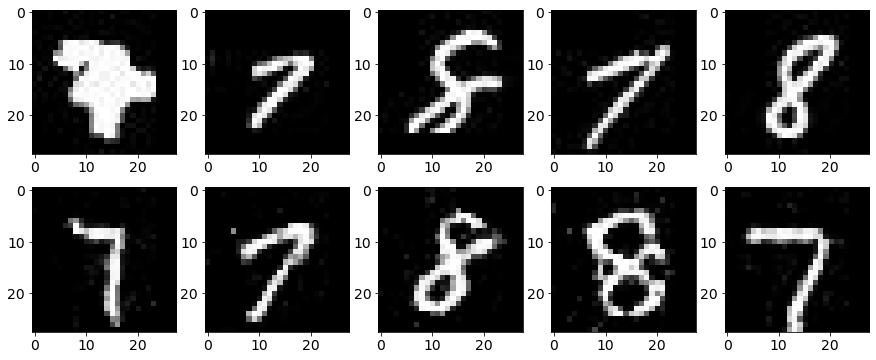

In [67]:
# 生成画像と訓練データを可視化する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')


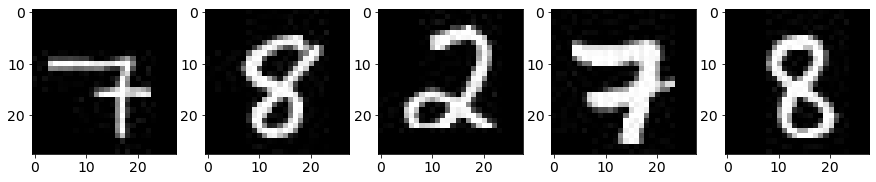

In [68]:
# テスト用のDataLoaderの作成


def make_test_datapath_list():
    """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(5):
        img_path = "./data/test_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


# ファイルリストを作成
test_img_list = make_test_datapath_list()

# Datasetを作成
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoaderを作成
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

# テストデータの確認
batch_iterator = iter(test_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')


In [69]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):

    # テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値を求めて、ミニバッチごとに和を求める
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # テスト画像xと生成画像fake_imgを識別器Dに入力し、特徴量マップを取り出す

    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    # テスト画像xと生成画像fake_imgの特徴量の差の絶対値を求めて、ミニバッチごとに和を求める
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # ミニバッチごとに2種類の損失を足し算する
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # ミニバッチ全部の損失を求める
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss

total loss： [148. 140. 254. 180. 136.]


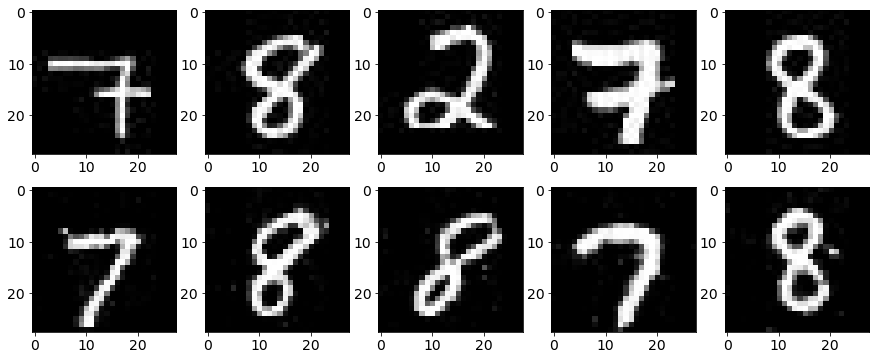

In [70]:
# 異常検知したい画像
x = imges[0:5]
x = x.to(device)

# 教師データの画像をエンコードしてzにしてから、Gで生成
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)

# 損失を求める
loss, loss_each, residual_loss_each = Anomaly_score(
    x, imges_reconstract, z_out_real, D_update, Lambda=0.1)

# 損失の計算。トータルの損失
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 画像を可視化
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')

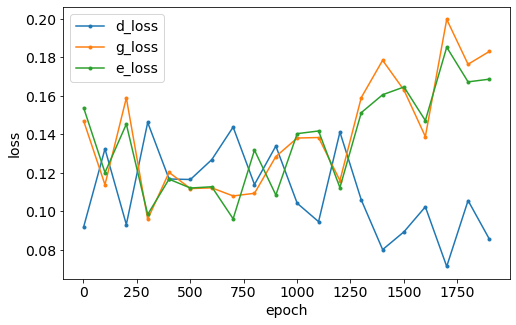

In [57]:
df = pd.read_csv('efficientGAN_loss.csv', index_col=0)

plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(8, 5))
for col in df.columns[1:]:
    plt.plot(df['epoch'], df[col], '.-', label=col)

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [76]:
steps = 10

batch_size = 5
start_input = torch.randn(batch_size, z_dim).view(batch_size, 20).to(device)

end_input =  torch.randn(batch_size, z_dim).view(batch_size, 20).to(device)

start_img = G_update(start_input)[1]
end_img = G_update(end_input)

vectors = []

alpha_values = np.linspace(0, 1, steps)
for alpha in alpha_values:
    vector = start_input * (1 - alpha) + end_input * alpha
    vectors.append(vector)

vectors = np.array(vectors)

imgs = []
for i, vec in enumerate(vectors):
    gen_img = G_update(vec)
    imgs.append(gen_img)

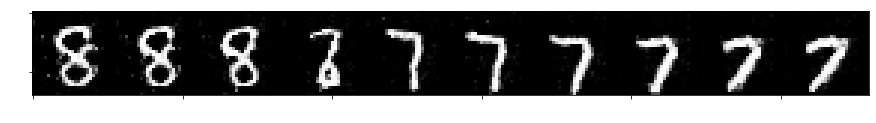

In [77]:
import cv2
concat_imgs = []
for i in range(len(imgs)):
    concat_imgs.append(imgs[i][0][0].cpu().detach().numpy())
    
fig = plt.figure(figsize=(15,5))
plt.imshow(cv2.hconcat(concat_imgs), 'gray')
plt.xticks(color="None")
plt.yticks(color="None")
plt.show()